In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D

from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler

from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE, SAMPLE, PAIRED_SAMPLES, get_experiment_artifacts
from src.models.outliers import logratio_outlier_detection
from src.util import calculate_difference_to_controls

In [3]:
sns.set_theme(style="white", palette="muted")
import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

In [4]:
HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE

('/Users/colm', 700, 'robust_cov', 'paired-replicates')

In [5]:
full_results_df = pd.read_pickle(get_experiment_artifacts() + "/augmented_with_GO_outlier_results.pkl")

In [6]:
full_results_df.columns

MultiIndex([(   'Global',                'Max Score'),
            (   'Global',         'Mean Consistency'),
            (   'Global',               'Mean Score'),
            (   'Global', 'Mean Std CLR Consistency'),
            (   'Global',     'Mean Std Consistency'),
            (       'T1',          'CLR Consistency'),
            (       'T1',              'Consistency'),
            (       'T1',                'distances'),
            (       'T1',                  'pvalues'),
            (       'T2',          'CLR Consistency'),
            (       'T2',              'Consistency'),
            (       'T2',                'distances'),
            (       'T2',                  'pvalues'),
            (       'T3',          'CLR Consistency'),
            (       'T3',              'Consistency'),
            (       'T3',                'distances'),
            (       'T3',                  'pvalues'),
            ('Gene Sets',                  'Adamson'),
          

### Standardisation

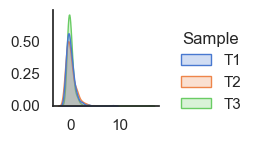

In [7]:
fig1a_df = {}
fig1a_df["Post-standardisation"] = full_results_df.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,:].xs("distances", level="Measure", axis=1)
fig1a_df["Post-standardisation"] = pd.DataFrame(StandardScaler().fit_transform(fig1a_df["Post-standardisation"]), columns=fig1a_df["Post-standardisation"].columns, index=fig1a_df["Post-standardisation"].index)
fig1a_df["Post-standardisation"] = fig1a_df["Post-standardisation"].stack().reset_index().rename(columns={0: "Mahalanobis Distance"})
fig1a_df = pd.concat(fig1a_df).reset_index().rename(columns={"level_0": "State"}).sort_values("Sample")
g = sns.displot(kind='kde', data=fig1a_df, x='Mahalanobis Distance', fill=True, col='State', hue="Sample", facet_kws={'sharex': False, 'sharey': False}, height=2, common_norm=False)
for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.savefig("artifacts/mini.pdf")
plt.savefig("artifacts/mini.png")

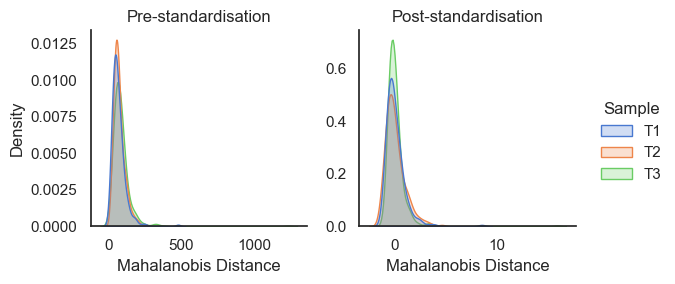

In [8]:
fig1a_df = {}
fig1a_df["Pre-standardisation"] = full_results_df.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,:].xs("distances", level="Measure", axis=1).stack().reset_index().rename(columns={0: "Mahalanobis Distance"})
fig1a_df["Post-standardisation"] = full_results_df.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,:].xs("distances", level="Measure", axis=1)
fig1a_df["Post-standardisation"] = pd.DataFrame(StandardScaler().fit_transform(fig1a_df["Post-standardisation"]), columns=fig1a_df["Post-standardisation"].columns, index=fig1a_df["Post-standardisation"].index)
fig1a_df["Post-standardisation"] = fig1a_df["Post-standardisation"].stack().reset_index().rename(columns={0: "Mahalanobis Distance"})
fig1a_df = pd.concat(fig1a_df).reset_index().rename(columns={"level_0": "State"}).sort_values("Sample")
g = sns.displot(kind='kde', data=fig1a_df, x='Mahalanobis Distance', fill=True, col='State', hue="Sample", facet_kws={'sharex': False, 'sharey': False}, height=3, common_norm=False)
for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name)
# plt.savefig("artifacts/fig_supplementary_1a.pdf")
# plt.savefig("artifacts/fig_supplementary_1a.png")

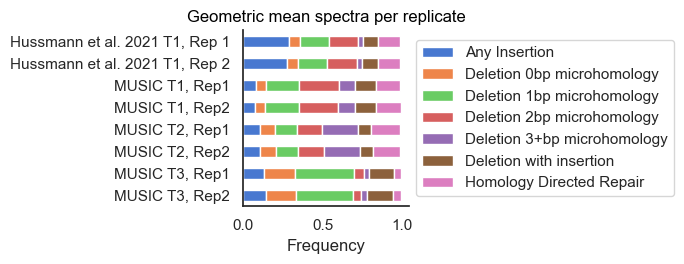

In [9]:
Z_sample = pkl.load(open("{}/imputed_adamson_sample_data.pkl"\
    .format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))

Z_sample.update(pkl.load(open("{}/imputed_sample_data.pkl"\
    .format(get_experiment_artifacts(profile_type=SAMPLE)), "rb")))

d_sample = pd.concat(Z_sample, axis=1).dropna()

Xall_sample = d_sample.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_sample.index.unique("Sample")

barplot_df = pd.DataFrame(Xall_sample.groupby("Sample").apply(stats.gmean).values.tolist(), index=Xall_sample.index.unique("Sample"), columns=Xall_sample.columns)
f = plt.figure(figsize=(7, 2.8))
plt.title('Geometric mean spectra per replicate', color='black')

barplot_df.plot(kind="barh", stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.yticks(np.arange(8), ['MUSIC T3, Rep2', 'MUSIC T3, Rep1',\
                          'MUSIC T2, Rep2', 'MUSIC T2, Rep1',\
                          'MUSIC T1, Rep2', 'MUSIC T1, Rep1',\
                          'Hussmann et al. 2021 T1, Rep 2', 'Hussmann et al. 2021 T1, Rep 1'])
plt.ylabel("")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("artifacts/fig_1b.pdf")
plt.savefig("artifacts/fig_1b.png")

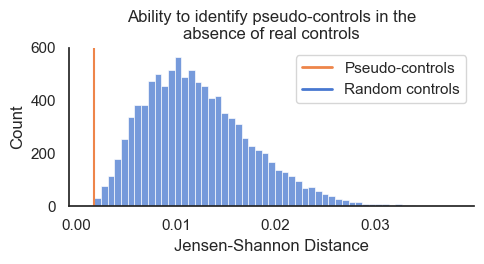

In [10]:
bootstrapped_means = pkl.load(open("../exploratory/outlier_analysis/artifacts/jsd_estimates.pkl", "rb"))

jensha_dis = bootstrapped_means["bootstrapped"]
pjsd = bootstrapped_means["pseudo"]
jsd = bootstrapped_means["actual"]

plt.figure(figsize=(5, 2.8))

sns.histplot(jensha_dis)
plt.axvline(pjsd, c=sns.color_palette()[1])
# plt.axvline(jsd, c=sns.color_palette()[1])
plt.ylim(0, 600)
# plt.annotate("Psuedo-\ncontrol\nprofile", (pjsd + 0.0005, 500), c="red")
# plt.annotate("Mean profile", (jsd + 0.0005, 570), c="grey")
plt.title("Ability to identify pseudo-controls in the\nabsence of real controls")
plt.xlabel("Jensen-Shannon Distance")
plt.ylabel("Count")
custom_lines = [Line2D([0], [0], color=sns.color_palette()[1], lw=2),
                Line2D([0], [0], color=sns.color_palette()[0], lw=2)]
plt.legend(custom_lines, ["Pseudo-controls", "Random controls"], ncols=1, loc="best")
plt.tight_layout()
plt.savefig("artifacts/fig_1c.pdf")
plt.savefig("artifacts/fig_1c.png")

In [11]:
pjsd

0.0018107942434974458

Alternatives:
box plot with 

- pseudo-controls distances to other genes 
- real control distances to other genes
- 4-5 random runs to other genes

In [12]:
Z_sample = pkl.load(open("{}/imputed_adamson_sample_data.pkl"\
    .format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
d_sample = pd.concat(Z_sample, axis=1)
target_sites = list(Z_sample.keys())
non_targetting_controls = d_sample.index.to_series()[d_sample.index.to_series().str.lower().str.contains("non-")]

In [13]:
non_targetting_controls.shape[0]

29

In [14]:
d_sample.index.shape[0] - non_targetting_controls.shape[0]

467

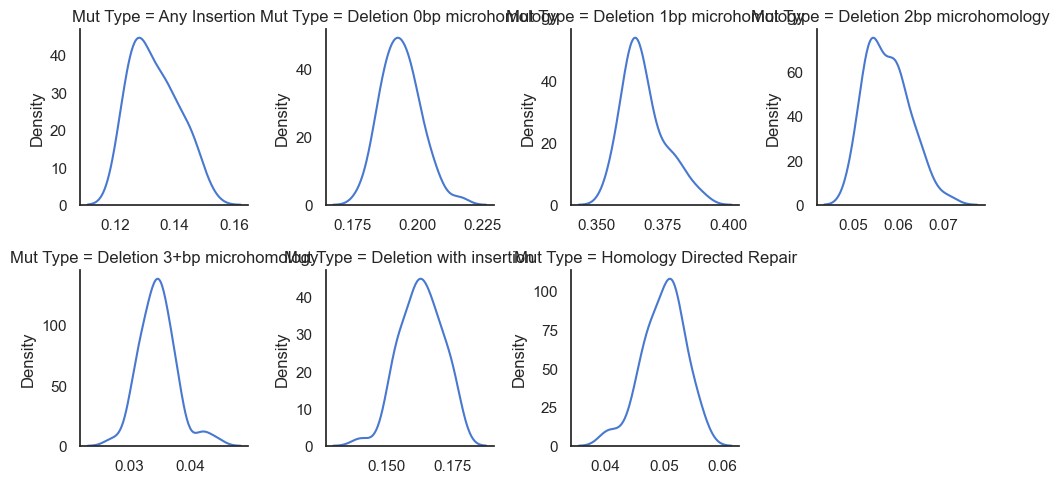

In [15]:
pooled_hussman_nontargetting_spectra = d_sample.loc[non_targetting_controls].reorder_levels(axis=1, order=[1, 0]).stack()
plot_d = pooled_hussman_nontargetting_spectra.stack().to_frame().reset_index()
plot_d = plot_d.rename(columns={"lumc_category": "Mut Type", "level_1": "Target Site"})
g = sns.FacetGrid(plot_d, col="Mut Type", col_wrap=4, sharey=False, sharex=False, height=2.5)
g.map_dataframe(sns.kdeplot)

In [17]:
Z_paired = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
d_paired = pd.concat(Z_paired, axis=1).dropna()
print(d_paired.shape)

Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")\
    .rename(columns={"Any Insertion": "Insertion"})
Xall_paired.index.unique("Sample")

idx = pd.IndexSlice
map_samples_to_target = {
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1": "Adamson_T1",
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2": "Adamson_T1",
}

results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, _ = \
        logratio_outlier_detection(d_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=d_paired[alias].index).sort_values(ascending=False)

pseudo_controls = {}
for alias in Z_paired.keys():
    pseudo_controls[alias] = results[alias].iloc[-29:].index.to_series()
pseudo_controls[alias][:5]
non_targetting_controls = d_sample.index.to_series()[d_sample.index.to_series().str.lower().str.contains("non-")]

Xdiff = {}
alias = "Adamson_T1"
Xdiff["Pseudo"] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], pseudo_controls[alias], [alias])
Xdiff["Non-targeting"] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], non_targetting_controls, [alias])

Xdiff = pd.concat(Xdiff, axis=1).droplevel(axis=1, level=1)

(496, 7)
(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)
(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)


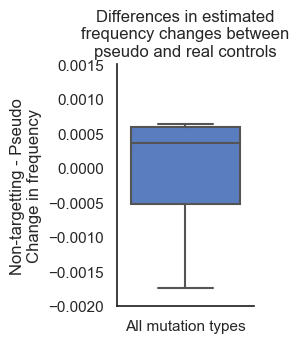

In [ ]:

tmp = Xdiff.stack()
tmp = tmp["Non-targeting"] - tmp["Pseudo"]
plt.figure(figsize=(2.8, 3.6))
sns.boxplot(tmp)

plt.title("Differences in estimated\nfrequency changes between\npseudo and real controls")
plt.xticks([0], ["All mutation types"])
plt.ylabel("Non-targetting - Pseudo\nChange in frequency")
plt.ylim((-0.002, 0.0015))
plt.tight_layout()

plt.savefig("artifacts/fig_1d.pdf")
plt.savefig("artifacts/fig_1d.png")

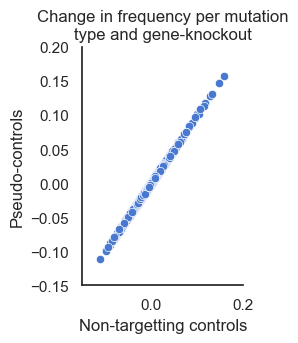

In [ ]:
plt.figure(figsize=(2.8, 3.6))

sns.scatterplot(data=Xdiff.stack(), x="Non-targeting", y="Pseudo")

plt.title("Change in frequency per mutation\ntype and gene-knockout")
plt.xlabel("Non-targetting controls")
plt.ylabel("Pseudo-controls")
plt.xlim((-.15,.2))
plt.ylim((-.15,.2))
plt.tight_layout()

plt.savefig("artifacts/fig_1e.pdf")
plt.savefig("artifacts/fig_1e.png")

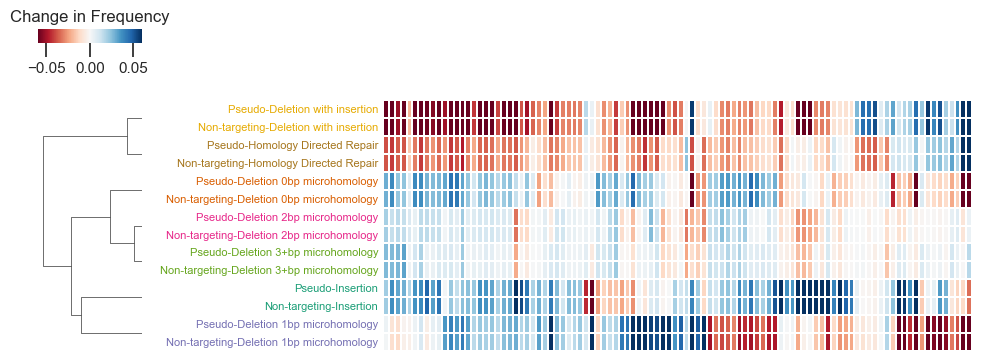

In [ ]:
Xdiff.columns = Xdiff.columns.rename(["Controls", "Mutational Outcome"])

pvalues = pd.Series(pvalues, index=d_paired[alias].index)
top_genes = pvalues.sort_values()[:100].index.to_series()
Xdiff = Xdiff.loc[top_genes, :]

pal = sns.color_palette('Dark2', Xdiff.columns.get_level_values("Mutational Outcome").unique().shape[0])
lut = dict(zip(Xdiff.columns.get_level_values("Mutational Outcome").unique(), pal))
col_colors = Xdiff.columns.get_level_values("Mutational Outcome").to_series().map(lut)
col_colors.index = Xdiff.columns

kws = dict(cbar_kws=dict(orientation='horizontal'))
cg = sns.clustermap(Xdiff.T, metric="correlation", method="ward", figsize=(10, 3.6), cbar_pos=(0, 1, 0.05, .0),\
                    cmap="RdBu", vmax=0.06, vmin=-0.06, center=0, dendrogram_ratio=(.15, .05), linewidths=.25, \
                        linecolor='white', clip_on=False, **kws)
cg.ax_heatmap.tick_params(axis='both', which='both', length=0, labelbottom=False, labeltop=False)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel(None)
cg.ax_heatmap.set_ylabel("")
cg.ax_heatmap.set_xticklabels([], fontsize = 8)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = 8)
cg.ax_col_dendrogram.set_visible(False)

x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([x0, 0.9, cg.ax_row_dendrogram.get_position().width, 0.00])
cg.ax_cbar.set_title('Change in Frequency')
cg.ax_cbar.tick_params(axis='x', length=10)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().rsplit("-", 1)[1]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_label.set_rotation(90)

plt.tight_layout()

plt.savefig("artifacts/fig_1f.pdf")
plt.savefig("artifacts/fig_1f.png")

In [ ]:
import pandas as pd
from src.config import get_interim_dir, get_experiment_artifacts
from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, TARGETDIFF, SAMPLE, PAIRED_SAMPLES, PROFILE_TYPE

targets = ["MB01", "MB02", "MB03", "MB04", "MB05", "MB06"]

X_orig = {}
X_imputed = {}
counts = {}

for alias in targets:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_all_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    X = X.loc[:, (X != 0).any(axis=0)]
    print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

    counts[alias] = X.sum(axis=1)

    X_orig[alias] = X

    X = impute_zero_values(X, 1)
    columns = X.columns
    # X = X.div(X.sum(axis=1), axis=0)
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)
    X.columns = columns

    X_imputed[alias] = X

print("Data Ready.")

0.9937929183349363
0.00 of our data is zero
0.9935922525524753
0.00 of our data is zero
0.9959820829954473
0.00 of our data is zero
0.9954643204383372
0.00 of our data is zero
0.9927946367701835
0.00 of our data is zero
0.9930757121463217
0.00 of our data is zero
Data Ready.


In [ ]:
def calculate_differential_profile(alias1, alias2, X_imputed):
    print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias1))
    print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias2))
    a = X_imputed[alias1]
    b = X_imputed[alias2]
    
    X = pd.concat([a, b], axis=0)
    columns = X.columns
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)

    Z_case = X
    print("There are {} cases".format(Z_case.shape[0]))

    return Z_case

Z_paired = {}

Z_paired["T1"] = calculate_differential_profile("MB01", "MB02", X_imputed)
Z_paired["T2"] = calculate_differential_profile("MB03", "MB04", X_imputed)
Z_paired["T3"] = calculate_differential_profile("MB05", "MB06", X_imputed)

print(Z_paired["T1"].shape[0], Z_paired["T2"].shape[0], Z_paired["T3"].shape[0])

There are 18406 genes in MB01
There are 18406 genes in MB02
There are 18406 cases
There are 18406 genes in MB03
There are 18406 genes in MB04
There are 18406 cases
There are 18406 genes in MB05
There are 18406 genes in MB06
There are 18406 cases
18406 18406 18406


In [ ]:
Z_paired.update(pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb")))
d_paired = pd.concat(Z_paired, axis=1).dropna()
print(d_paired.shape)

Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")\
    .rename(columns={"Any Insertion": "Insertion"})
Xall_paired.index.unique("Sample")

(434, 28)


Index(['Adamson_T1', 'T1', 'T2', 'T3'], dtype='object', name='Sample')

In [ ]:
d_paired

T1                             \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Actl6a                          0.137474                   0.144097   
Actr5                           0.098129                   0.131709   
Actr8                           0.096966                   0.157150   
Aicda                           0.099942                   0.139256   
Alkbh2                          0.100111                   0.137117   
...                                  ...                        ...   
Ybx3                            0.105036                   0.129134   
Yeats4                          0.113388                   0.134482   
Yy1                             0.120454                   0.145467   
Znhit1                          0.061547                   0.143011   
Zranb3                          0.105370                   0.131774   

                                                                  \
lumc_category Deletion 2bp microhomology Deletion with insertion   
Gene                                                               
Actl6a                          0.140589                0.068836   
Actr5                           0.154463                0.088310   
Actr8                           0.156002                0.084195   
Aicda                           0.166238                0.094238   
Alkbh2                          0.171450                0.082784   
...                                  ...                     ...   
Ybx3                            0.154908                0.091070   
Yeats4                          0.154667                0.076191   
Yy1                             0.140547                0.081796   
Znhit1                          0.150868                0.057371   
Zranb3                          0.146916                0.079695   

                                                      \
lumc_category Homology Directed Repair Any Insertion   
Gene                                                   
Actl6a                        0.146968      0.156989   
Actr5                         0.224807      0.097949   
Actr8                         0.184362      0.110393   
Aicda                         0.173125      0.112227   
Alkbh2                        0.185400      0.099949   
...                                ...           ...   
Ybx3                          0.183111      0.109236   
Yeats4                        0.124949      0.124261   
Yy1                           0.175838      0.098215   
Znhit1                        0.185275      0.132816   
Zranb3                        0.200750      0.102499   

                                                                  T2  \
lumc_category Deletion 3+bp microhomology Deletion 0bp microhomology   
Gene                                                                   
Actl6a                           0.205047                   0.043391   
Actr5                            0.204633                   0.064345   
Actr8                            0.210931                   0.076438   
Aicda                            0.214974                   0.070314   
Alkbh2                           0.223189                   0.067390   
...                                   ...                        ...   
Ybx3                             0.227504                   0.065096   
Yeats4                           0.272063                   0.075558   
Yy1                              0.237682                   0.064965   
Znhit1                           0.269111                   0.068125   
Zranb3                           0.232996                   0.064069   

                                                                     ...  \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology  ...   
Gene                                                                 ...   
Actl6a                          0.227209                   0.232424 

In [ ]:
results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = \
        logratio_outlier_detection(d_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=d_paired[alias].index).sort_values(ascending=False)

In [ ]:
all_results = pd.concat(results, axis=1)

all_results = pd.DataFrame(StandardScaler().fit_transform(all_results.values), index=all_results.index, columns=all_results.columns)
top_genes = all_results.mean(axis=1).sort_values()[-100:].index.to_list()

In [ ]:
pseudo_controls = {}
for alias in Z_paired.keys():
    pseudo_controls[alias] = results[alias].iloc[-29:].index.to_series()
pseudo_controls[alias][:5]

Gene
Ogg1      Ogg1
Ezh1      Ezh1
Sprtn    Sprtn
Ercc1    Ercc1
Per1      Per1
Name: Gene, dtype: object

In [ ]:
idx = pd.IndexSlice
map_samples_to_target = {
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1": "Adamson_T1",
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2": "Adamson_T1",
    "MB01": "T1",
    "MB02": "T1",
    "MB03": "T2",
    "MB04": "T2",
    "MB05": "T3",
    "MB06": "T3",
}

Xpseudodiff = {}
for alias in Z_paired.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], pseudo_controls[alias], [alias])
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

(434, 7)
(29, 7)
(434, 7)
(7,)
(434, 7)
(434, 7)
(29, 7)
(434, 7)
(7,)
(434, 7)
(434, 7)
(29, 7)
(434, 7)
(7,)
(434, 7)
(434, 7)
(29, 7)
(434, 7)
(7,)
(434, 7)


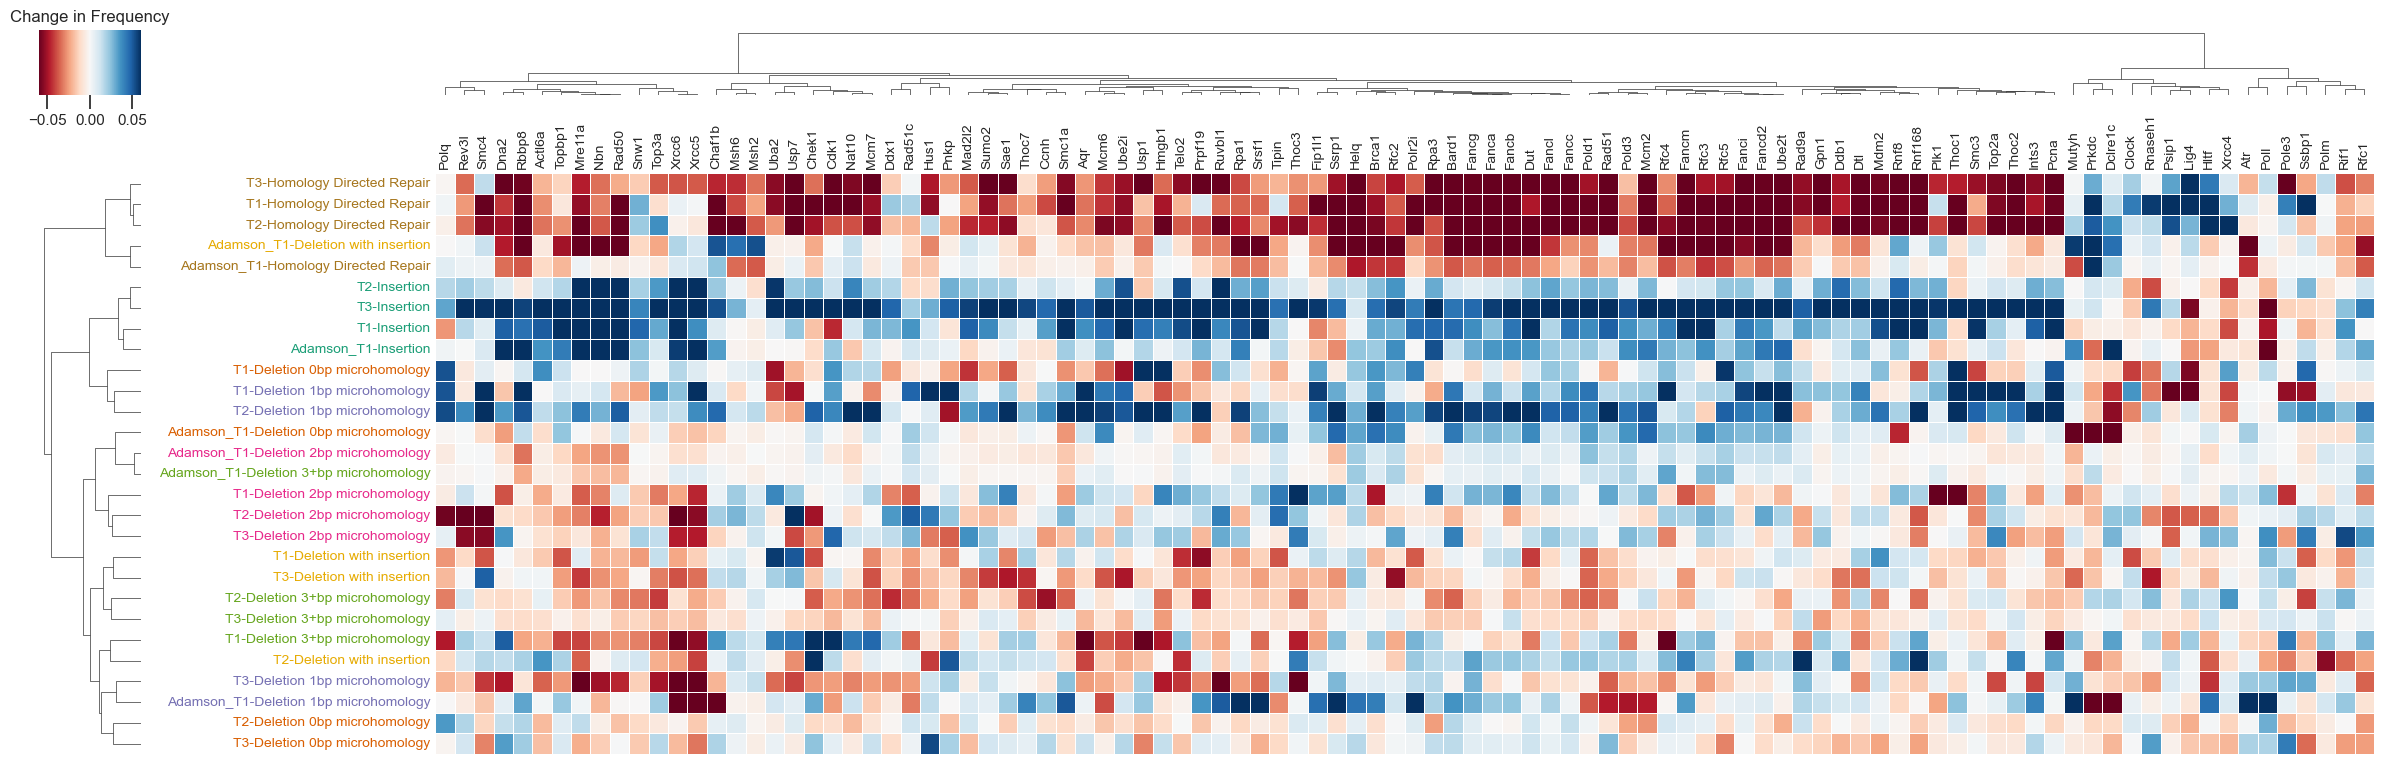

In [ ]:
Xpseudodiff.columns = Xpseudodiff.columns.rename(["Target", "Mutational Outcome"])
Xpseudodiff = Xpseudodiff.loc[top_genes, :]

pal = sns.color_palette('Dark2', Xpseudodiff.columns.get_level_values("Mutational Outcome").unique().shape[0])
lut = dict(zip(Xpseudodiff.columns.get_level_values("Mutational Outcome").unique(), pal))
col_colors = Xpseudodiff.columns.get_level_values("Mutational Outcome").to_series().map(lut)

kws = dict(cbar_kws=dict(orientation='horizontal'))
cg = sns.clustermap(Xpseudodiff.T, metric="correlation", method="ward", figsize=(24, 7.6),\
                    center=0, dendrogram_ratio=(.05, .1), cmap="RdBu", vmax=0.06, vmin=-0.06,\
                    cbar_pos=(0, .9, .01, .1), linewidths=.5, linecolor='white', clip_on=False, **kws)
cg.ax_heatmap.tick_params(axis='both', which='both', length=0)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel(None)
cg.ax_heatmap.set_ylabel("")
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = 10)

x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([x0, 0.9, cg.ax_row_dendrogram.get_position().width, 0])
cg.ax_cbar.set_title('Change in Frequency')
cg.ax_cbar.tick_params(axis='x', length=10)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().rsplit("-", 1)[1]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_label.set_rotation(90)


# rect = patches.Rectangle((42, 0), 6, Xpseudodiff.shape[1], linewidth=4, edgecolor="yellow", facecolor='none', fill=False, label="My label")
# cg.ax_heatmap.add_patch(rect)
# cg.ax_heatmap.text(-0.2, -0.2,'lalala')


# rect = patches.Rectangle((24, 0), 2, Xpseudodiff.shape[1], linewidth=4, edgecolor="aqua", facecolor='none', fill=False)
# cg.ax_heatmap.add_patch(rect)

plt.tight_layout()
plt.savefig("artifacts/fig_2.pdf")
plt.savefig("artifacts/fig_2.png")

In [ ]:
from src.config import get_common_barcodes, get_adamson_barcodes

barcodes = pd.read_csv(get_common_barcodes(), sep="\t")
adamson_barcodes = pd.read_csv(get_adamson_barcodes(), sep="\t")

# df = pd.concat([barcodes, adamson_barcodes])
print(barcodes.groupby(["Target", "Alias"]).mean()[["Counts"]].median())

print(adamson_barcodes.groupby(["Target", "Alias"]).mean()[["Counts"]].median())

Counts    2361.082631
dtype: float64
Counts    656201.975911
dtype: float64


In [ ]:
barcodes["Barcode"].nunique()

89571

In [ ]:
targets = ["MB01", "MB02", "MB03", "MB04", "MB05", "MB06"]

X_orig = {}
X_imputed = {}
counts = {}

for alias in targets:
    X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_all_repair_outcome_profiles.{}.pkl".format(alias, FILTER_COUNT))
    X = X.loc[:, (X != 0).any(axis=0)]
    print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

    counts[alias] = X.sum(axis=1)

    X_orig[alias] = X

    X = impute_zero_values(X, 1)
    columns = X.columns
    X = X.groupby(["Gene"]).apply(stats.gmean)
    X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
    X = X.div(X.sum(axis=1), axis=0)
    X.columns = columns

    X_imputed[alias] = X

print("Data Ready.")

0.9937929183349363
0.00 of our data is zero
0.9935922525524753
0.00 of our data is zero
0.9959820829954473
0.00 of our data is zero
0.9954643204383372
0.00 of our data is zero
0.9927946367701835
0.00 of our data is zero
0.9930757121463217
0.00 of our data is zero
Data Ready.


In [ ]:
Z_paired = {}

Z_paired["T1"] = calculate_differential_profile("MB01", "MB02", X_imputed)
Z_paired["T2"] = calculate_differential_profile("MB03", "MB04", X_imputed)
Z_paired["T3"] = calculate_differential_profile("MB05", "MB06", X_imputed)

print(Z_paired["T1"].shape[0], Z_paired["T2"].shape[0], Z_paired["T3"].shape[0])

d_paired = pd.concat(Z_paired, axis=1).dropna()

Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")\
    .rename(columns={"Any Insertion": "Insertion"})
Xall_paired.index.unique("Sample")

There are 18406 genes in MB01
There are 18406 genes in MB02
There are 18406 cases
There are 18406 genes in MB03
There are 18406 genes in MB04
There are 18406 cases
There are 18406 genes in MB05
There are 18406 genes in MB06
There are 18406 cases
18406 18406 18406


Index(['T1', 'T2', 'T3'], dtype='object', name='Sample')

In [ ]:
results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = \
        logratio_outlier_detection(d_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=d_paired[alias].index).sort_values(ascending=False)

In [ ]:
pca_scores.shape

(18406, 7)

In [ ]:
final_genes = pd.read_csv("../exploratory/outlier_detection/artifacts/final_gene_list.tsv", sep="\t", usecols=[0, 5, 6], skiprows=1)[1:].rename(columns={"Measure": "Gene"})
top_genes = final_genes["Gene"][:100]
top_genes[:5]

1    Atp6v1g1
2      H2ac18
3      Metap2
4       Xrcc5
5        H2ax
Name: Gene, dtype: object

In [ ]:
pseudo_controls = {}
for alias in Z_paired.keys():
    pseudo_controls[alias] = results[alias].iloc[-29:].index.to_series()
pseudo_controls[alias][:5]

Gene
Cercam      Cercam
Mfsd6l      Mfsd6l
Nlrp3        Nlrp3
Pcdhgc3    Pcdhgc3
Apba3        Apba3
Name: Gene, dtype: object

In [ ]:
Xpseudodiff = {}
for alias in Z_paired.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall_paired.loc[Xall_paired.index.get_level_values(0) == alias, :], pseudo_controls[alias], [alias])
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

(18406, 7)
(29, 7)
(18406, 7)
(7,)
(18406, 7)
(18406, 7)
(29, 7)
(18406, 7)
(7,)
(18406, 7)
(18406, 7)
(29, 7)
(18406, 7)
(7,)
(18406, 7)


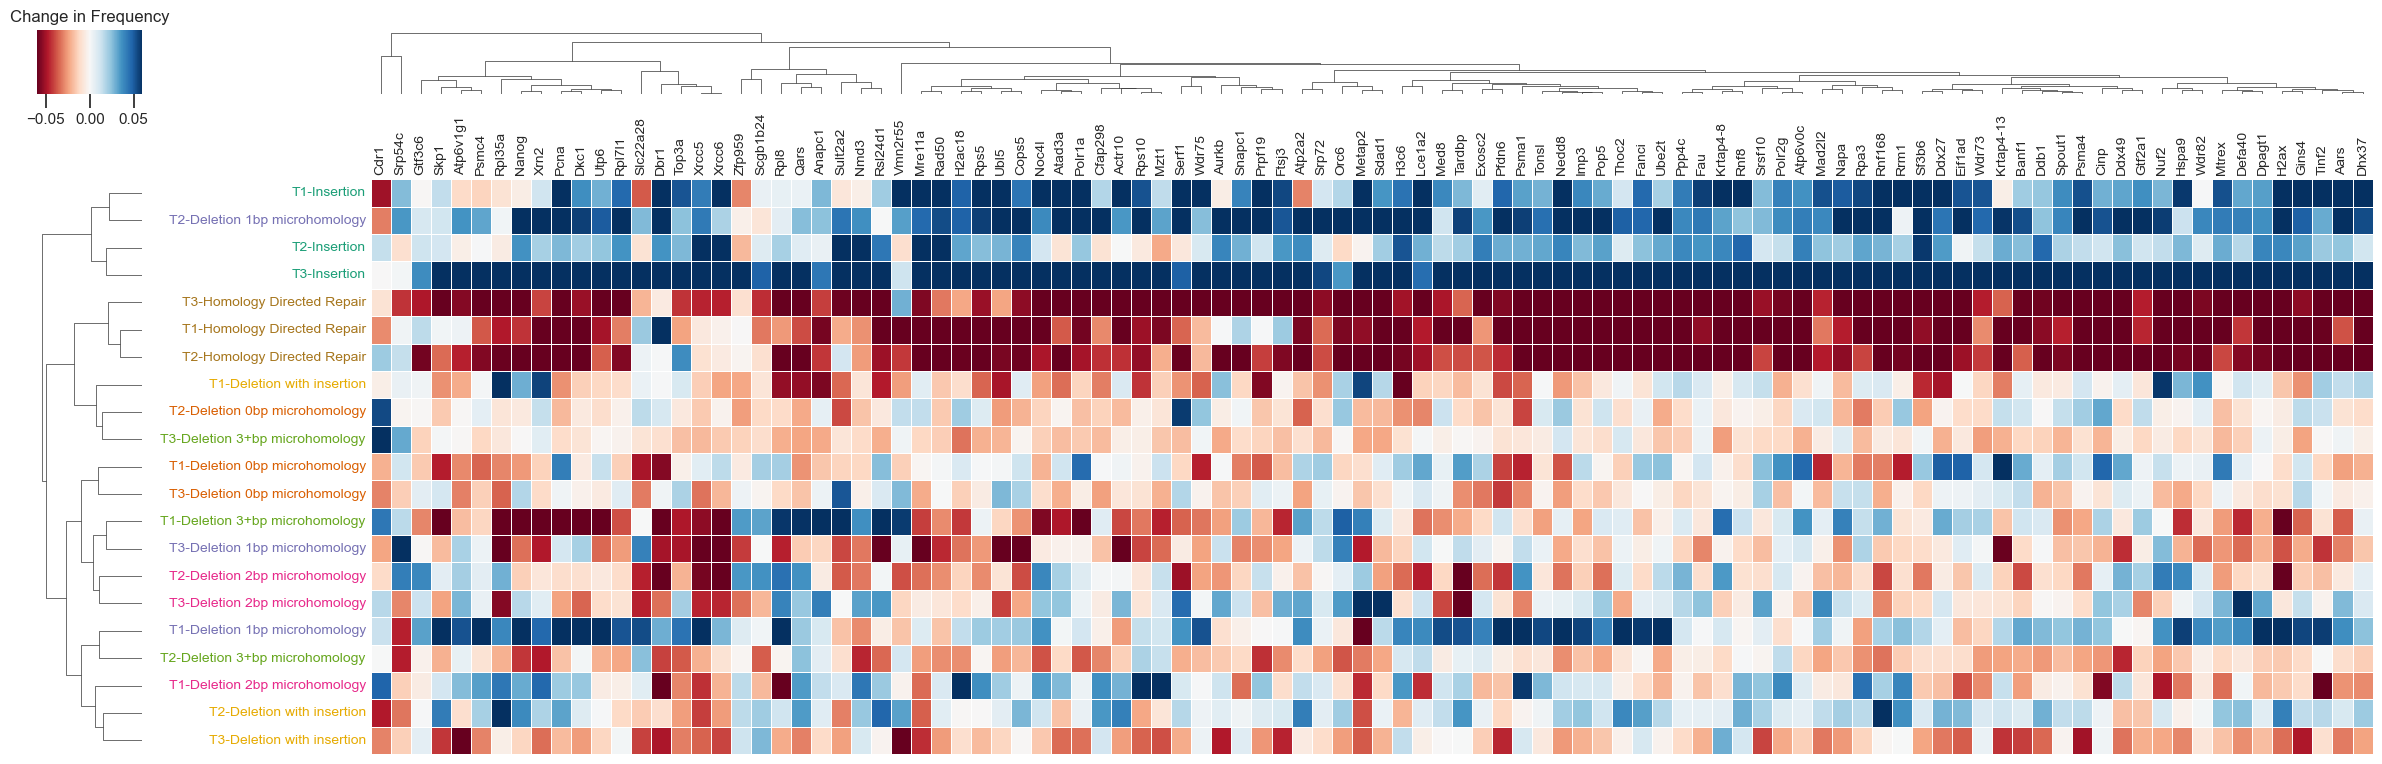

In [ ]:
Xpseudodiff.columns = Xpseudodiff.columns.rename(["Target", "Mutational Outcome"])
Xpseudodiff = Xpseudodiff.loc[top_genes, :]

pal = sns.color_palette('Dark2', Xpseudodiff.columns.get_level_values("Mutational Outcome").unique().shape[0])
lut = dict(zip(Xpseudodiff.columns.get_level_values("Mutational Outcome").unique(), pal))
col_colors = Xpseudodiff.columns.get_level_values("Mutational Outcome").to_series().map(lut)

kws = dict(cbar_kws=dict(orientation='horizontal'))
cg = sns.clustermap(Xpseudodiff.T, metric="correlation", method="ward", figsize=(24, 7.6),\
                    center=0, dendrogram_ratio=(.05, .1), cmap="RdBu", vmax=0.06, vmin=-0.06,\
                    cbar_pos=(0, .9, .01, .1), linewidths=.5, linecolor='white', clip_on=False, **kws)
cg.ax_heatmap.tick_params(axis='both', which='both', length=0)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel(None)
cg.ax_heatmap.set_ylabel("")
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = 10)

x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([x0, 0.9, cg.ax_row_dendrogram.get_position().width, 0])
cg.ax_cbar.set_title('Change in Frequency')
cg.ax_cbar.tick_params(axis='x', length=10)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_yticklabels()):
    tick_text = tick_label.get_text().rsplit("-", 1)[1]
    tick_label.set_color(lut[tick_text])
    tick_label.set_rotation(0)

for i, tick_label in enumerate(cg.ax_heatmap.axes.get_xticklabels()):
    tick_label.set_rotation(90)

plt.tight_layout()